0.00	0.00	images/local_skew-1.jpg
0.43	0.43	got characters
2.16	1.73	got words & tuples


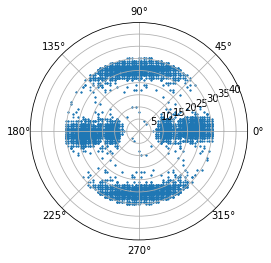

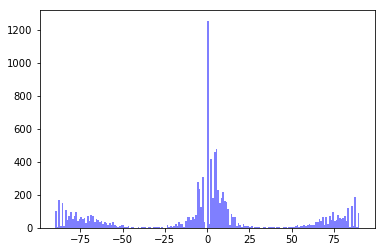

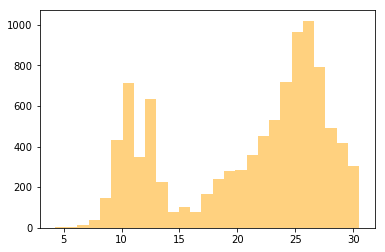

3.65	1.48	built Docstrum
3.65	0.00	finished analysing page
average time: 11.78

214
214


In [6]:
#!/usr/bin/python
# find . -name '.DS_Store' -type f -delete
# Chulwoo Pack

import sys
import os
from page import Page

SHOW_STEPS = True    # change this to false if you just want to see the final output for each page.
SAVE_OUTPUT = True
SAVE_DOCSTRUM = True

inputFolder = os.path.join('images')
outputFolder = os.path.join('output')

    
inputPath = os.path.join(inputFolder, os.listdir(inputFolder)[0])
outputPath = os.path.join(outputFolder, os.listdir(inputFolder)[0])

page = Page(inputPath, SHOW_STEPS, SAVE_DOCSTRUM)
#page = Page(inputPath, SHOW_STEPS)
    
if SAVE_OUTPUT:
    page.save(outputPath)  # save a copy of what is displayed. Used for getting images for the paper.
    
page.show((800, 800))

In [ ]:
# DOCSTRUM PLOTING TEST
import numpy as np
import matplotlib.pyplot as plt
# radtodeg(0.5880026035475674) = 33.6901
# radtodeg(0.21687361566640817) = 12.4259
#theta = [np.pi+(0.5880026035475674), np.pi+0.21687361566640817, 2*np.pi-(0.5880026035475674), 2*np.pi-(0.21687361566640817)] 
theta = [1/2*np.pi+(0.5880026035475674), 1/2*np.pi+(0.21687361566640817),3/2*np.pi+(0.5880026035475674), 3/2*np.pi+(0.21687361566640817)] 
r = [57.688820407423826, 60.41522986797286, 57.688820407423826, 60.41522986797286]
fig = plt.figure()
ax = plt.subplot(111,polar=True)
ax.scatter(theta,r)
plt.savefig(os.path.join(os.path.abspath("./docstrums"),'foo'))
plt.show()